In [1]:
import os
import glob
import numpy as np
import cv2

import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt


ext = 'png'
dataset_path = '../data/kunli'
video_name='simple diffusion mode_0'
video_path = os.path.join(dataset_path, video_name + '.avi')

digit = 5
dir_path = os.path.join(dataset_path, video_name)
base_path = os.path.join(dir_path, 'frame')

w=100

downsample=4

#cap = cv2.VideoCapture(video_path)

#while True:
#    ret, frame = cap.read()
#    ret

#ret, frame = cap.read()
#print(ret)
#print(np.shape(np.mean(frame,-1)))

## save individual frames in folder

In [ ]:
def save_all_frames(video_path, dir_path, basename, ext):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        return

    os.makedirs(dir_path, exist_ok=True)
    base_path = os.path.join(dir_path, basename)

    digit = len(str(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))))

    n = 0

    while True:
        ret, frame = cap.read()
        ret
        if ret:
            cv2.imwrite('{}_{}.{}'.format(base_path, str(n).zfill(digit), ext), np.mean(frame,-1))
            n += 1
        else:
            return

In [ ]:
save_all_frames(video_path , os.path.join(dataset_path, video_name),  'frame', ext)

## select or load training set

In [ ]:

x=[]


crop=np.empty([0,w,w])

dir_path = os.path.join(dataset_path, video_name)

base_path = os.path.join(dir_path, 'frame')


n=1
frame = cv2.imread('{}_{}.{}'.format(base_path, str(n).zfill(digit), ext)).mean(-1)


plt.imshow(frame, cmap="gray")
plt.axis("off")
x=plt.ginput(n=-1, timeout=-1,show_clicks=True)
for i, val in enumerate(x):
    crop=np.append(crop, np.array([frame[int(val[1]-w/2):int(val[1]+w/2), int(val[0]-w/2):int(val[0]+w/2)]]),0)



### load training set

In [ ]:
import pickle
with open(os.path.join(dataset_path, video_name + '_trainset.pickle'),'rb') as f:
    crop = pickle.load(f)
    f.close()

### add more crops

In [ ]:
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt

n=6450 #179 184 188 190 199 200 201 202 203 204 645 6451
frame = cv2.imread('{}_{}.{}'.format(base_path, str(n).zfill(digit), ext)).mean(-1)

plt.figure(figsize=(12, 12))
plt.imshow(frame, cmap="gray")
plt.axis("off")
x=plt.ginput(n=-1, timeout=-1,show_clicks=True)
for i, val in enumerate(x):
    crop=np.append(crop, np.array([frame[int(val[1]-w/2):int(val[1]+w/2), int(val[0]-w/2):int(val[0]+w/2)]]),0)


In [ ]:
%matplotlib inline
from IPython import display
import time
for i, val in enumerate(crop):
   plt.imshow(val, cmap="gray")
   plt.axis("off")
   display.display(plt.gcf())
   display.clear_output(wait=True)
   time.sleep(0.5)

### save training set

In [ ]:
import pickle
with open(os.path.join(dataset_path, video_name + '_trainset.pickle'), 'wb') as f:
        pickle.dump(crop, f)
        f.close()

## augmentations

In [ ]:
%matplotlib inline

import deeptrack as dt
import random

train_set =   (
    #dt.Value(crop[4,:,:])
    dt.Value(lambda:random.choice(crop)) # translate=lambda:np.random.uniform(-10, 10, 2), rotate=lambda:np.random.uniform(0, np.pi*2)
    >> dt.Affine(scale=lambda:np.random.uniform(0.9, 1.2, 2),   rotate=lambda:np.random.uniform(-np.pi, np.pi))
    >> dt.Add(lambda: np.random.randn() * 0.3 )
    >> dt.Gaussian(sigma=lambda:np.random.uniform(0, 0.05))
    >> dt.Multiply(lambda: np.random.uniform(0.8, 1.1)) #0,2 , 1.1   # 0,6 ha set el millor
    >> dt.AveragePooling((downsample, downsample))
    #>> dt.NormalizeMinMax(min=lambda:0, max=lambda:1)
)  
image=train_set.update().resolve()
plt.imshow(image, cmap="gray")
plt.axis("off")

## train LodeSTAR model

In [ ]:
model = dt.models.LodeSTAR(input_shape=(None, None, 1))
#
train_set =   (
    dt.Value(lambda:random.choice(crop)) # translate=lambda:np.random.uniform(-10, 10, 2), 
    >> dt.Affine(scale=lambda:np.random.uniform(0.9, 1.2, 2),   rotate=lambda:np.random.uniform(-np.pi, np.pi))
    >> dt.Add(lambda: np.random.randn() * 0.3 )
    >> dt.Gaussian(sigma=lambda:np.random.uniform(0, 0.05))
    >> dt.Multiply(lambda: np.random.uniform(0.8, 1.1)) #0,2 , 1.1   # 0,6 ha set el millor
    >> dt.AveragePooling((downsample, downsample))
    #>> dt.NormalizeMinMax(min=lambda:0, max=lambda:1)
) 
#
model.fit(
    train_set,
    epochs=10,
    batch_size=8,
    generator_kwargs=dict(min_data_size=1000, max_data_size=1001), # number of augmented images in training set
    steps_per_epoch=300 # 
    )

### save model

In [ ]:
model.save(os.path.join(dataset_path, 'models',"LodeSTAR1"))

### load model

In [6]:
import deeptrack as dt
import tensorflow as tf
saved_model = tf.keras.models.load_model(os.path.join(dataset_path, 'models' ,"LodeSTAR1"))
model = dt.models.LodeSTAR(saved_model.model)

## check results (test)

1/1 [==============================] - 0s 45ms/step


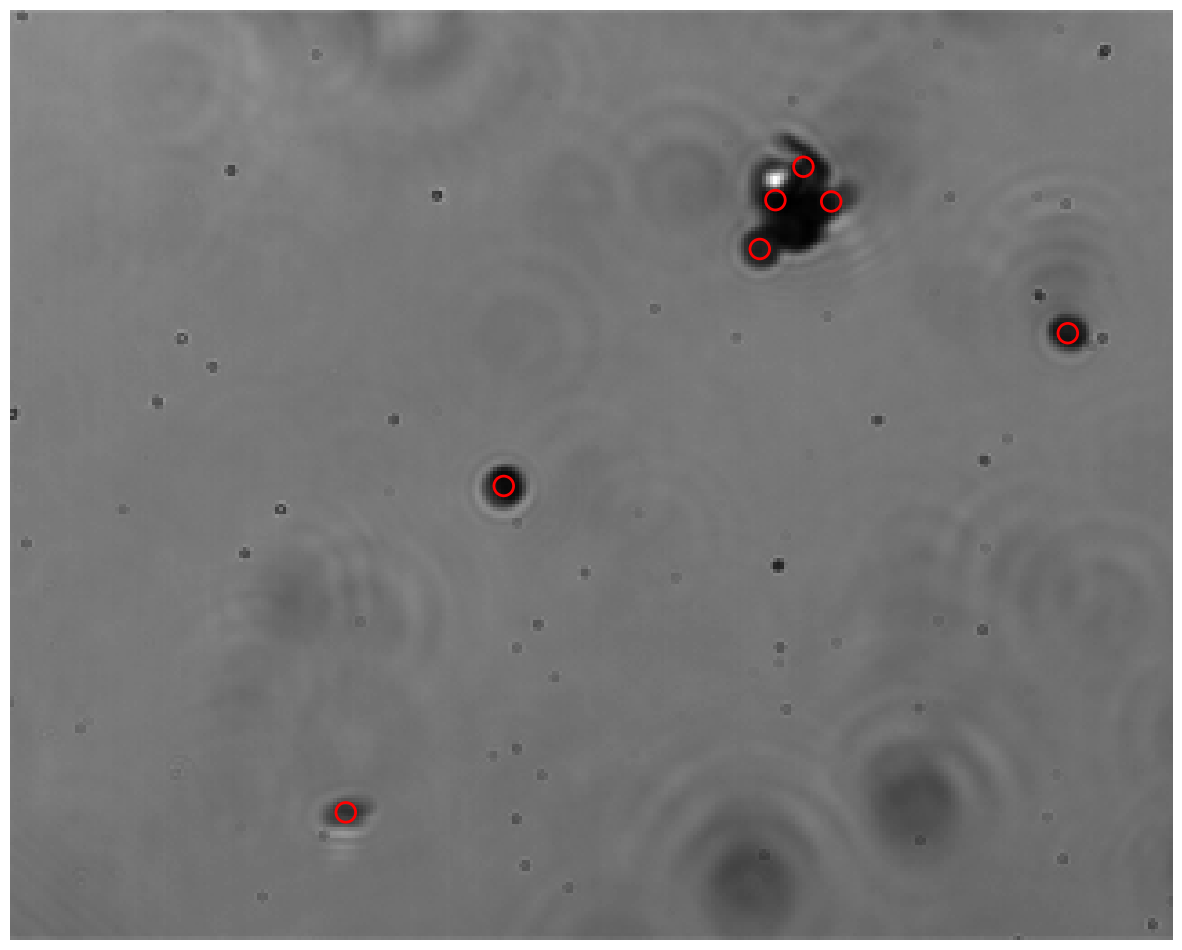

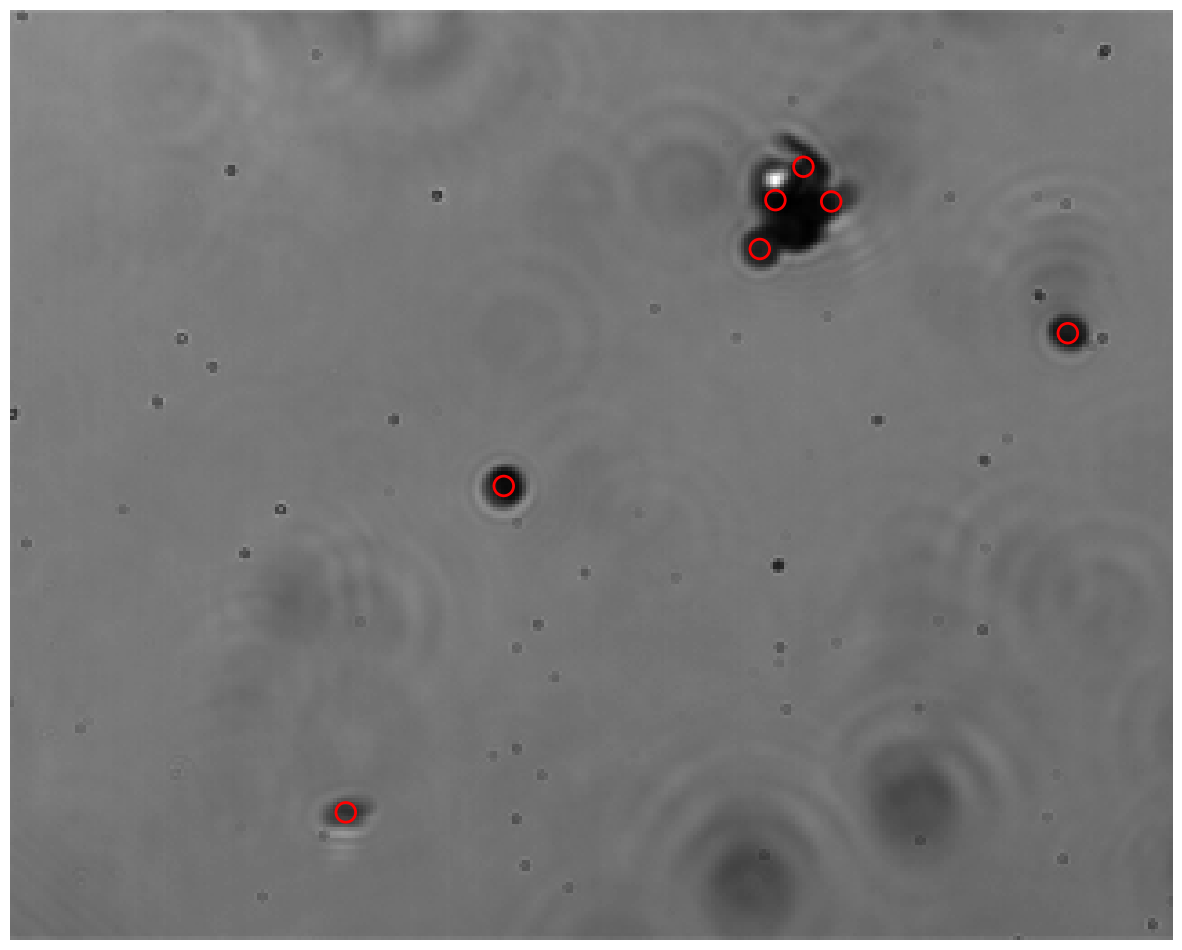

In [8]:
%matplotlib inline

alpha = .5 #1 lower values care more about shape, 1 (high) don't care about shape % parameter for calculating the score
cutoff = .3   #[0,1]  mode can be changed to quantile or ratio 

n=14396
image = cv2.imread('{}_{}.{}'.format(base_path, str(n).zfill(digit), ext)).mean(-1)
image = (
    dt.Value(image)
    >> dt.AveragePooling((downsample, downsample))
    #>> dt.NormalizeMinMax(min=lambda:0, max=lambda:1)
    ).resolve()


detections = model.predict_and_detect(image[np.newaxis], alpha=alpha, beta=1-alpha, cutoff=cutoff, mode="constant")[0] #if density don't change write quantile instead of constant

fig = plt.figure(figsize=(15, 15))
plt.imshow(image, cmap='gray')#, vmin=0, vmax=1)
plt.axis("off")
plt.scatter(detections[:, 1], detections[:, 0], s=200, linewidths=2, facecolors="none", edgecolors="r")
#plt.savefig(folder_path + "frame_" + str(frame_index) + ".png")
#plt.close(fig)


In [9]:
import json

def get_annotations(frame, positions):
    annotation = {
        "frame": frame,
        "count": len(positions),
        "coordinates": positions,
    }
    return annotation

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


## get all detections

In [ ]:
plot = False
import re

annotations = []

entries = sorted(os.listdir(dir_path))
for filename in entries[0:1500]:  ## testing on a few frames only, comment after entries to get all
    frame_index = re.findall("frame_(\d+).png", filename)
    frame_index=int(frame_index[0])

    image = cv2.imread(os.path.join(dir_path,filename)).mean(-1)
    image = (
        dt.Value(image)
        >> dt.AveragePooling((downsample, downsample))
        #>> dt.NormalizeMinMax(min=lambda:0, max=lambda:1)
        ).resolve()

    detections = model.predict_and_detect(image[np.newaxis], alpha=alpha, beta=1-alpha, cutoff=cutoff, mode="constant")[0] #if density don't change write quantile instead of constant

    if plot:
        fig = plt.figure(figsize=(15, 15))
        plt.imshow(image, cmap='gray')#, vmin=0, vmax=1)
        plt.text(10, 10, filename, c="white", fontsize=20)
        plt.axis("off")
        plt.scatter(detections[:, 1], detections[:, 0], s=60, linewidths=2, facecolors="none", edgecolors="r")
        #plt.savefig(folder_path + "frame_" + str(frame_index) + ".png")
        #plt.close(fig)

    annotations.append(get_annotations(frame_index, detections))

with open(os.path.join(dataset_path, video_name + '_detections.json'), "w",) as outfile:
    json.dump(annotations, outfile, cls=NumpyEncoder)

## do some MAGIK

In [11]:
import sys
sys.path.append("./cellmot")
import matplotlib.pyplot as plt
import pandas as pd
import json

import cellmot as cm
from cellmot import deeptrack as dt

#import deeptrack as dt

import tensorflow as tf

import logging
logging.disable(logging.WARNING)

# Output type
_OUTPUT_TYPE = "edges"

# Seach radius for the graph edges
radius = .2

variables = dt.DummyFeature(
    radius=radius,
    min_data_size=511,
    max_data_size=512,
    batch_size=1,
    output_type=_OUTPUT_TYPE,
    nofframes=3,
)

/Users/841602/Documents/GitHub/Course-ETH/soft matter/X application AX lodestar_localization/materials/cellmot/deeptrack/backend/_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
/Users/841602/Documents/GitHub/Course-ETH/soft matter/X application AX lodestar_localization/materials/cellmot/deeptrack/backend/_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")


In [12]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


def get_annotations(idx, positions):
    annotation = {
        "idx": idx,
        "length": np.shape(positions)[0],
        "coordinates": positions,
    }
    return annotation

In [13]:
_LOAD_MODEL = True

model = dt.models.gnns.MAGIK(
    dense_layer_dimensions=(64, 96,),   # number of features in each dense encoder layer
    base_layer_dimensions=(96, 96, 96),        # Latent dimension throughout the message passing layers
    number_of_node_features=2,             # Number of node features in the graphs
    number_of_edge_features=1,             # Number of edge features in the graphs
    number_of_edge_outputs=1,              # Number of predicted features
    edge_output_activation="sigmoid",      # Activation function for the output layer
    output_type=_OUTPUT_TYPE,              # Output type. Either "edges", "nodes", or "graph"
)


# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = 'binary_crossentropy',
    metrics=['accuracy'],
)
model.model.summary()

if _LOAD_MODEL:
    print("Loading model...")
    model.load_weights(os.path.join(dataset_path, 'models','MAGIK.h5'))
#else:
    # generator = cm.GraphGenerator(**variables.properties())
    
    # with generator:
    #     model.fit(generator, epochs=10)

    # print("saving model...")
    # os.makedirs("models/", exist_ok=True)
    # model.save_weights("../models/MAGIK.h5")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 2)]    0           []                               
                                                                                                  
 node_ide1 (Dense)              (None, None, 64)     192         ['input_1[0][0]']                
                                                                                                  
 lambda_3 (Lambda)              multiple             0           ['node_ide1[0][0]',              
                                                                  'edge_ide1[0][0]',              
                                                                  'node_ide2[0][0]',              
                                                                  'edge_ide2[0][0]',          

In [ ]:
# Create dataframe from detections
dfs = cm.create_df(
        path = os.path.join(dataset_path, video_name + '_detections.json'), 
        scaling=320,
        )
# Get results
pred, gt, scores, graph = cm.get_predictions(dfs, model, variables)

# Crate dataframe from results
edges_df, nodes, _ = cm.df_from_results(pred, gt, scores, graph)

# Get trajectories from results
traj_out = cm.get_traj(edges_df, th = 8)

/var/folders/m1/pc2jmjl93c7chdf35rtyxdg0h6sh_6/T/ipykernel_34884/578935803.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(detections[-1, 2] * 320 , detections[-1, 1] * 300 * 4, linewidths=1.5, c = c,) #edgecolors=c)


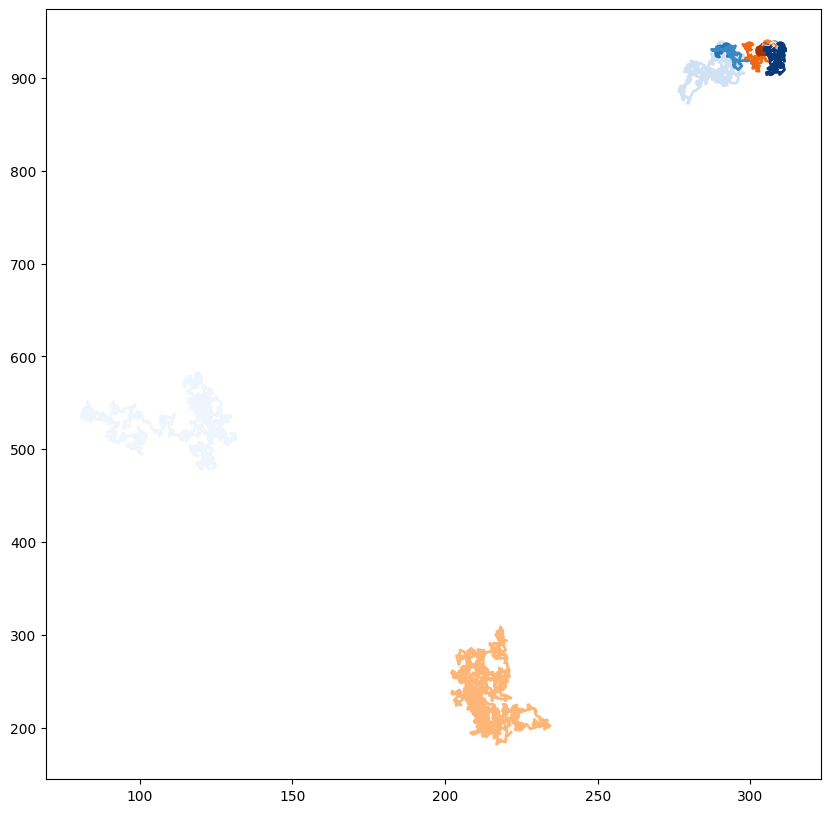

In [15]:
%matplotlib inline

# for j in range(50):
#     frame = j
fig = plt.figure(figsize=(10, 10))
#     #plt.imshow(v)
#     #plt.text(10, 40, "Frame: " + str(frame), fontsize=20, c="white")
#     #plt.axis('off')
frame = 50
for i, (t, c) in enumerate(traj_out):
    detections = nodes[t]#[nodes[t, 0], :]

# check the multiplicative factors 320 vs 1200???
    plt.plot(detections[:, 2] * 320, detections[:, 1] * 300 * 4, color = c, linewidth=2)
    plt.scatter(detections[-1, 2] * 320 , detections[-1, 1] * 300 * 4, linewidths=1.5, c = c,) #edgecolors=c)
    

In [16]:
def TAMSD(traj, t_lags):
    '''
    Calculates the time average mean squared displacement of a set of trajectories
    Inputs: - traj: trajectory to calculate TA-MSD
            - t_lags: time lags used for the TA-MSD
    Outputs: - TA-MSD
    '''
    tamsd = np.zeros_like(t_lags, dtype= float)
    for idx, t in enumerate(t_lags):        
        for p in range(len(traj)-t):
            tamsd[idx] += sum((traj[p]-traj[p+t])**2  )         
        tamsd[idx] /= len(traj)-t    
    return tamsd

In [17]:
trajs=[]

for i, (t, c) in enumerate(traj_out):
    trajs.append(nodes[t][:,1:])#[nodes[t, 0], :])

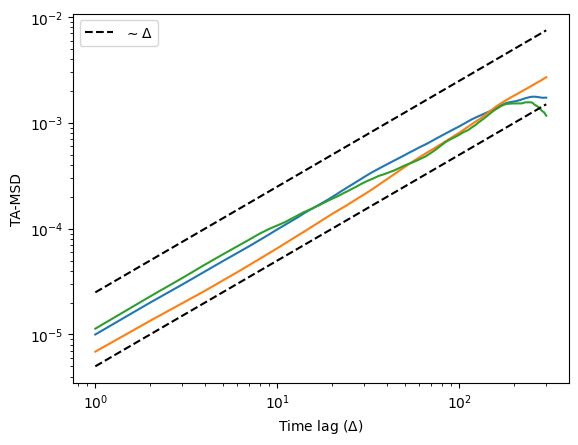

: 

In [29]:
t_lags = np.arange(1, 301)
#alpha=1.85

for traj in trajs:
    if len(traj)>300:
        tamsd = TAMSD(traj, t_lags)    
        plt.loglog(t_lags,tamsd)
    
plt.loglog(t_lags, 0.000025*t_lags, c = 'k', ls = '--', label = r'$\sim\Delta$')
plt.loglog(t_lags, 0.000005*t_lags, c = 'k', ls = '--',)
#plt.loglog(t_lags, 0.000001*t_lags**alpha, c = 'k', ls = '--', label = r'$\Delta^\alpha$')
plt.xlabel(r'Time lag ($\Delta$)')
plt.ylabel('TA-MSD')
# plt.yscale('linear')
# plt.xscale('linear')
plt.legend()